#Clustering algorithms

There are multiple options when one wishes to pick a clustering algorithm. Some of them, you can find at link: <a href="http://scikit-learn.org/stable/modules/clustering.html">SCKIT learn</a> <br>
My problem is geographical. I have to find shops that are close together.  Mainly so that a customer will not consider jumping into a car and driving to a some other shop. When a person gets in a car, it is entirely possible to drive few minutes more to a some distant location. <br>
On the other hand, it is necessary to encompass the average mall where people usually do walk from one shop to another. <br>
So I will here compare two clusters, simple K-means, and DBSCAN, the algorithm recommended for geographical applications. 

#The data set

I'll use dataset from YELP data challenge. And from there take dataset describing businesses and their locations in Las Vegas, Nevada. 

In [2]:
#general
import numpy as np
import scipy
from matplotlib import pyplot as plt
%pylab inline
import pandas as pd
import MySQLdb
import os
import sys
sys.setrecursionlimit(3000)

Populating the interactive namespace from numpy and matplotlib


In [5]:
con=MySQLdb.connect(user=user, passwd=passwd, db=dbname, host=host)
df2 = pd.read_sql("SELECT longitude, latitude FROM business WHERE state = 'NV'", con)
print "data loaded"

data loaded


And here is simple scatter plot of the data set.

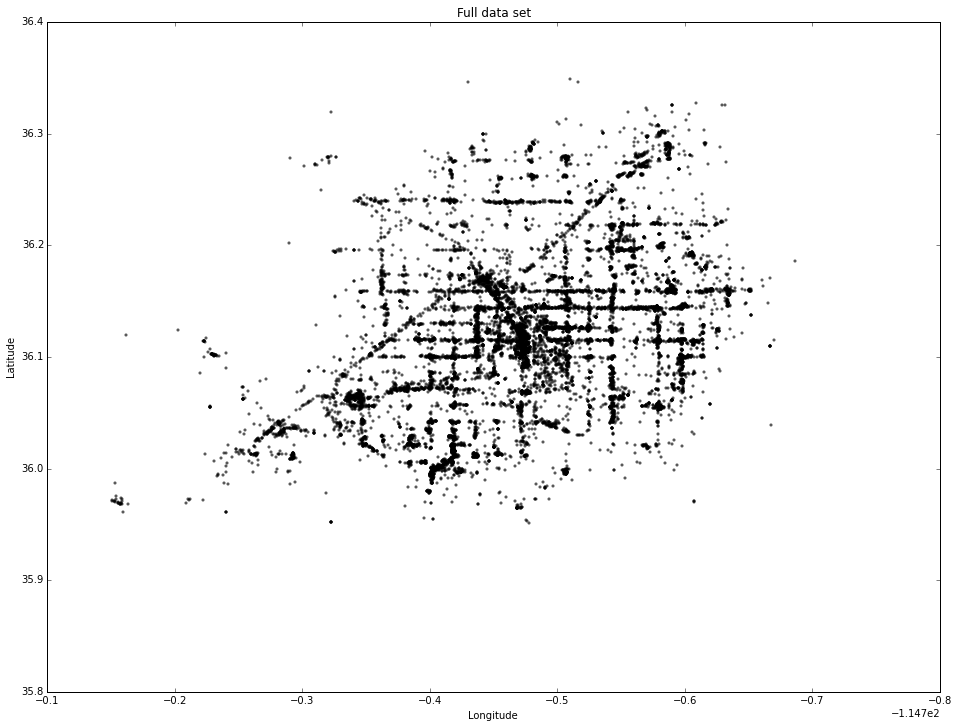

In [14]:

plt.figure(figsize=(16, 12), dpi=100)
df_scatter = plt.scatter(df2['longitude'], df2['latitude'], c='k', alpha=.5, s=5)
plt.title('Full data set')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-114.8,-115.5)
plt.ylim(35.8,36.4)
plt.show()

#K-means

For this I'l; use Python and scipy’s k-means clustering algorithm to reduce the full data set of GPS coordinates to a smaller but (approximately) spatially representative set of 100 points. 

In [6]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, kmeans2, whiten

I'll convert the latitude and longitude columns into a two-dimensional numpy array, called coordinates. The k-means algorithm groups N observations into k clusters. I’ll set k=100. I’ll also tell the routine to perform 50 iterations by setting i=50.
<br><br>
I will normalize the coordinate data with the whiten function. According to the scipy documentation: “Each feature is divided by its standard deviation across all observations to give it unit variance.” The whitened data yields results that are more spatially representative of the original, full data set.

In [13]:
coordinates = df2.as_matrix(columns=['longitude', 'latitude'])
N = len(coordinates)
k = 100
i = 50
w = whiten(coordinates)

I’m going to use the kmeans2 function because it returns both an array of cluster centroids as well as an array of centroid IDs that each observation in the data set is closest to. Then I plot the cluster centroids against the original data set:

In [14]:
cluster_centroids, closest_centroids = kmeans2(w, k, iter=i)

/Users/Lexa/anaconda/lib/python2.7/site-packages/scipy/cluster/vq.py:600: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


Yeah, and here is a warning that one of the clusters is empty. Let us see what is going on. 

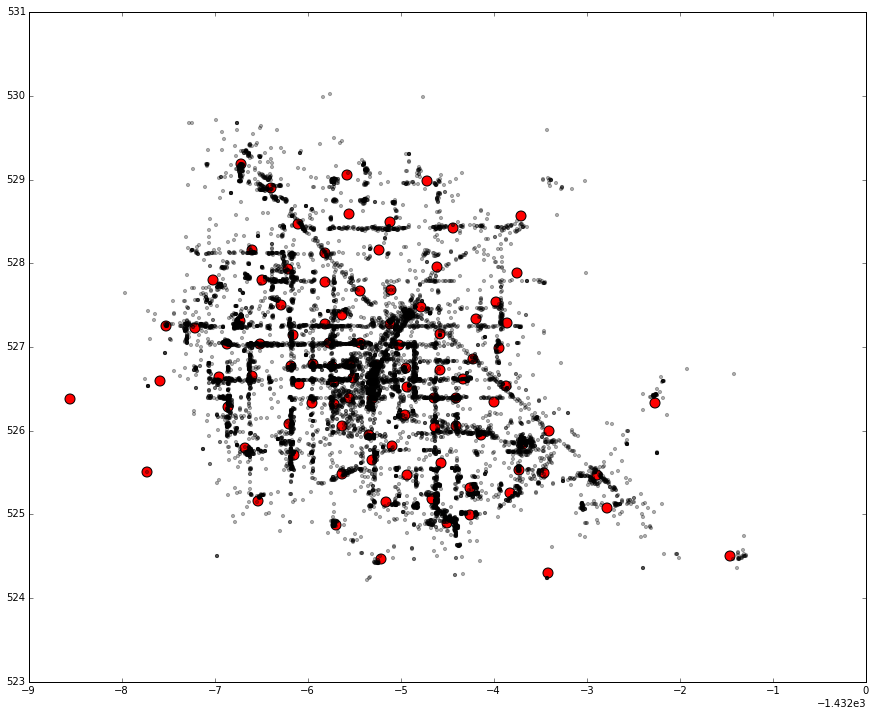

In [15]:
plt.figure(figsize=(15, 12), dpi=100)
plt.scatter(cluster_centroids[:,0], cluster_centroids[:,1], c='r', s=100)
plt.scatter(w[:,0], w[:,1], c='k', alpha=.3, s=10)
plt.show()

It is not hard to locate the empty cluster. Let us try to solve this glitch. <br>

The kmeans2 function uses a random distribution of points from the entire coordinate space as its initial condition. Since the data is not evenly distributed, kmeans2 converges to this nearly random-looking result. <br> I need to tell the kmeans2 function to initialize with a random distribution of actual points from the data set:

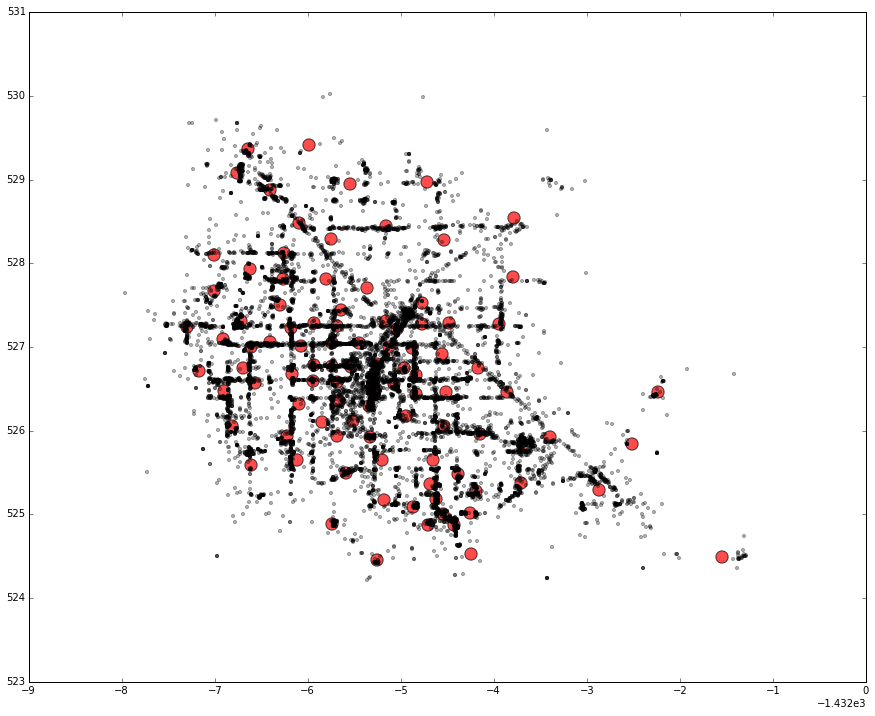

In [9]:
cluster_centroids, closest_centroids = kmeans2(w, k, iter=i, minit='points')
plt.figure(figsize=(15, 12), dpi=100)
plt.scatter(cluster_centroids[:,0], cluster_centroids[:,1], c='r', alpha=.7, s=150)
plt.scatter(w[:,0], w[:,1], c='k', alpha=.3, s=10)
plt.show()

Better, but not great. In the preceding plot you see the 100 cluster centroids, in red, generally approximating the spatial distribution of the normalized full data set, in gray/black (due to us setting the opacity alpha value to 0.3, each of these points’ grayscale darkness is dependent on how many points are stacked on top of each other at that spot).

Now, let’s check to see if the numbers add up:

In [20]:
print 'k =', k
print 'N =', N
print len(cluster_centroids)
print len(closest_centroids)
print len(np.unique(closest_centroids))

k = 100
N = 16485
100
16485
100


The number of closest_centroids should be the same as N. The number of cluster_centroids and the number of unique elements in closest_centroids should be the same as k. Everything looks correct, algorithmically.<br>
I’ll add a new column to the original full data set, called closest_centroid. For each set of coordinates in the original data set, I’ll add the closest centroid ID from the kmeans2 clustering to this new column. Then, I’ll reduce the data set so there is only one row for each value of closest_centroid.

In [16]:
rs = pd.DataFrame(df2)
rs['closest_centroid'] = closest_centroids
rs.drop_duplicates(subset=['closest_centroid'], take_last=False, inplace=True)

This dataframe has 100 rows. Each row contains a single data point (from the original data set) that belongs to each of the 100 clusters that were formed. Let’s plot the final (not whitened, like I did earlier) reduced set of coordinate points vs the original full set:

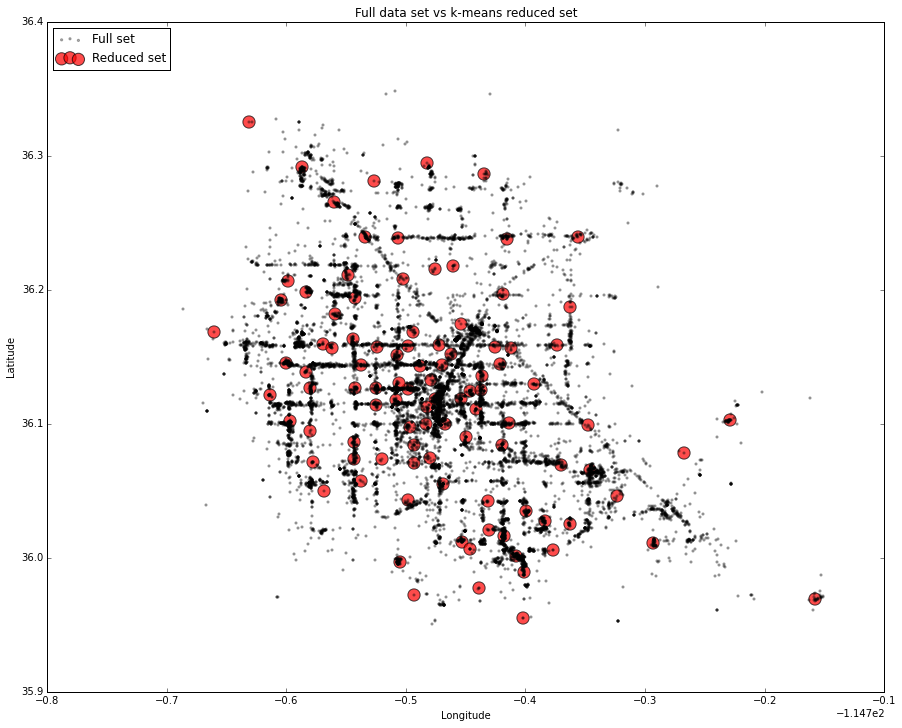

In [11]:
plt.figure(figsize=(15, 12), dpi=100)
rs_scatter = plt.scatter(rs['longitude'], rs['latitude'], c='r', alpha=.7, s=150)
df_scatter = plt.scatter(df2['longitude'], df2['latitude'], c='k', alpha=.3, s=5)
plt.title('Full data set vs k-means reduced set')
plt.legend((df_scatter, rs_scatter), ('Full set', 'Reduced set'), loc='upper left')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

On one hand, the reduced data set does more-or-less approximate the spatial distribution of the full data set. On the other hand, there are gaps.<br> Even worse, many locations from the full data set are not part of any cluster, and thus are lost from the reduced data set. Why?
<br>
The answer is that k-means is not an ideal algorithm for lat-long spatial data. It minimizes variance, not geodetic distance – there is substantial distortion at latitudes far from the equator, like those of this data set. The algorithm still works, but its results are not great and there isn’t much that can be done to improve them. Increasing the number of clusters still leaves patchy gaps throughout the reduced data set.

#Better spatial data clustering with DBSCAN

This time using an algorithm that works better with arbitrary distances: scikit-learn’s implementation of the DBSCAN algorithm. DBSCAN clusters a spatial data set based on two parameters: a physical distance from each point, and a minimum cluster size. This works much better for spatial lat-long data. 

In [18]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
db = DBSCAN(eps=.006, min_samples=2).fit(coordinates)
labels = db.labels_
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
clusters = pd.Series([coordinates[labels == i] for i in xrange(num_clusters)])
print('Number of clusters: %d' % num_clusters)

Number of clusters: 155


Ok, now I’ve got 155 clusters. Unlike k-means, DBSCAN doesn’t require you to specify the number of clusters in advance – it determines them automatically. <br>
For plot, it would be more spatially-representative to take the point nearest the cluster’s centroid. This simple function returns the coordinates of the centroid of an array of points:

In [19]:
def getCentroid(points):
    n = points.shape[0]
    sum_lon = np.sum(points[:, 1])
    sum_lat = np.sum(points[:, 0])
    return (sum_lon/n, sum_lat/n)

I need a function that takes a set of points and returns the point in it that is nearest to some other reference point. In this case, that other reference point will be the centroid I calculated in the previous function.
<br>
First I calculate the great circle distance between the reference point and each point in the set, using geopy’s great circle function. Then I return the coordinates of the point that was the smallest distance from the reference:

In [20]:
def getNearestPoint(set_of_points, point_of_reference):
    closest_point = None
    closest_dist = None
    for point in set_of_points:
        point = (point[1], point[0])
        dist = great_circle(point_of_reference, point).meters
        if (closest_dist is None) or (dist < closest_dist):
            closest_point = point
            closest_dist = dist
    return closest_point

First create two lists to hold the latitudes and longitudes. Then iterate through the series of clusters. If there are only one or two points in the cluster, I can just take the first point – it doesn’t make sense to calculate the centroid in these cases.
<br><br>
If there are three or more points in the cluster, I’ll find the point in the cluster that is closest to its centroid using the two functions I just defined. Then I add each point’s coordinates to the latitude and longitude lists. Once I’ve cycled through every cluster, save the final reduced set of points to a new pandas dataframe:

In [21]:
lon = []
lat = []
for i, cluster in clusters.iteritems():
    if len(cluster) < 3:
        representative_point = (cluster[0][1], cluster[0][0])
    else:
        representative_point = getNearestPoint(cluster, getCentroid(cluster))
    lon.append(representative_point[0])
    lat.append(representative_point[1])
rsD = pd.DataFrame({'lon':lon, 'lat':lat})

I’ll plot the final reduced set of data points against the original full set. <br>
First let us check the coordinates of the clusters.

In [26]:
rsD.head(5)

,lat,lon
0,-115.182005,36.118819
1,-115.150017,36.021178
2,-115.112145,36.008311
3,-115.176493,36.239052
4,-115.244809,36.062318


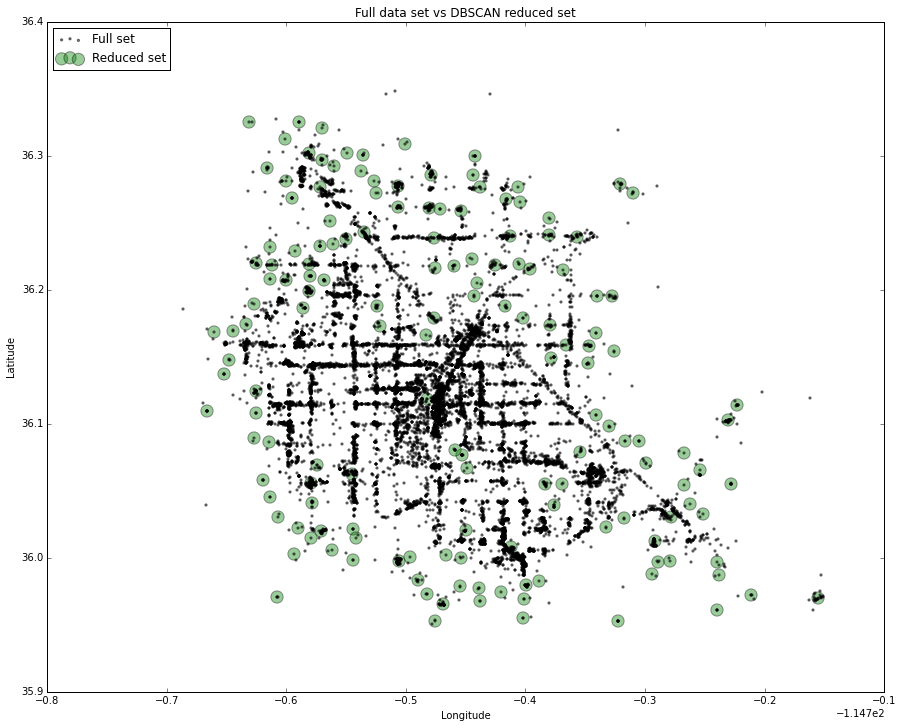

In [28]:
plt.figure(figsize=(15, 12), dpi=100)
rs_scatter = plt.scatter(rsD['lat'], rsD['lon'], c='g', alpha=.4, s=150)
df_scatter = plt.scatter(df2['longitude'], df2['latitude'], c='k', alpha=.5, s=5)
plt.title('Full data set vs DBSCAN reduced set')
plt.legend((df_scatter, rs_scatter), ('Full set', 'Reduced set'), loc='upper left')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

And these look much better. Although, around the strip, it is hard to see clusters. However, there is one. 

##And everything on a map!

And now, let us put those clusters on the map. <br>
I will use Folium package for the example. 

In [78]:
from IPython.display import HTML
import folium
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 310px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))


In [81]:
meanlat=df2.latitude.mean()
meanlong=df2.longitude.mean()

map = folium.Map(width=600,height=600,location=[meanlat,meanlong], zoom_start=10)

for i in range(len(latRS)):
    map.simple_marker([rsD.lon[i], rsD.lat[i]], popup='Add <b>popup</b> Recommended location.',marker_color='blue',marker_icon='ok-sign',clustered_marker=True)
    


inline_map(map)

So as a conclusion, for the geographical clusters, DBSCAN is way to go. 